## InversionNet - CurveVel-A (Adam Optimizer)

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt

import os
import sys

import warnings
warnings.filterwarnings('ignore')


import tqdm
from model import *

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import scipy.ndimage

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchmetrics.functional import mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda:0")  
    torch.cuda.empty_cache()
    print("Total number of GPU available -",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

Total number of GPU available - 8


## Loading Amplitude and Velocity Data for Curve Layers

In [2]:
#loading amplitude data
data1 = np.load('CurveVel-A/amplitude/data1.npy')
data2 = np.load('CurveVel-A/amplitude/data2.npy')
data3 = np.load('CurveVel-A/amplitude/data3.npy')
data4 = np.load('CurveVel-A/amplitude/data4.npy')

#loading velocity data
model1 = np.load('CurveVel-A/velocity/model1.npy')
model2 = np.load('CurveVel-A/velocity/model2.npy')
model3 = np.load('CurveVel-A/velocity/model3.npy')
model4 = np.load('CurveVel-A/velocity/model4.npy')


# converting to torch tensor
data1 = torch.tensor(data1).type(dtype).to(device)
data2 = torch.tensor(data2).type(dtype).to(device)
data3 = torch.tensor(data3).type(dtype).to(device)
data4 = torch.tensor(data4).type(dtype).to(device)

model1 = torch.tensor(model1).type(dtype).to(device)
model2 = torch.tensor(model2).type(dtype).to(device)
model3 = torch.tensor(model3).type(dtype).to(device)
model4 = torch.tensor(model4).type(dtype).to(device)

## Custom Data Loader class to load data using PyTorch Dataloader

In [3]:
class DatasetLoader(Dataset):
    
    def __init__(self, amps, vel):
        self.amps = amps
        self.vel = vel
    
    
    def __getitem__(self, idx):
        
        return (self.amps[idx], self.vel[idx])
    
    def __len__(self):
        
        return len(self.amps)


In [4]:
total_data = torch.cat((data1, data2, data3, data4), 0)
total_model = torch.cat((model1, model2, model3, model4), 0)

data = DatasetLoader(total_data, total_model)

In [5]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size

train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])

trainloader = DataLoader(train_data, batch_size=50, shuffle=True)
testloader = DataLoader(test_data, batch_size=50, shuffle=False)

## Defining InversionNet model

In [6]:
input_channels = 5
encoder_channels = [32, 64, 64, 64, 64, 128, 128, 128, 128,
                   256, 256, 256, 256, 512]

decoder_channels = [512, 256, 128, 64, 32]

net = InversionNetB(input_channels, encoder_channels, decoder_channels).type(dtype).to(device)

# net = nn.DataParallel(InversionNetB(input_channels, encoder_channels, decoder_channels)).type(dtype).to(device)

#net = InversionNet().type(dtype).to(device)

In [7]:
# Optimization Params
params = [p for p in net.parameters()]

l2_loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params':params, 'lr':1e-6}])

  0%|                                                  | 0/2000 [00:00<?, ?it/s]

Model Loss at 0 epoch - 8498405.75


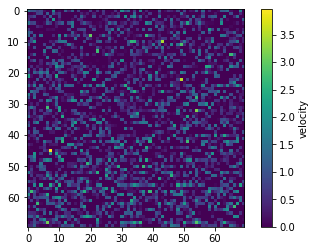

 10%|███▊                                  | 200/2000 [18:53<2:49:19,  5.64s/it]

Model Loss at 200 epoch - 8497194.015625


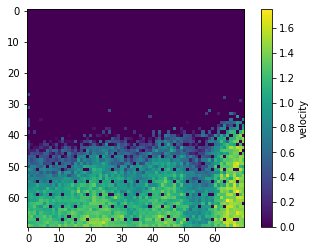

 20%|███████▌                              | 400/2000 [39:07<3:12:48,  7.23s/it]

Model Loss at 400 epoch - 8497131.734375


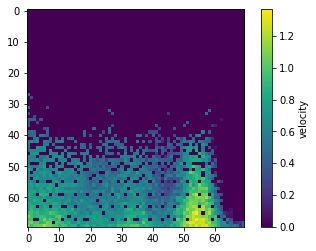

 20%|███████▋                              | 405/2000 [39:49<3:37:17,  8.17s/it]

In [ ]:
# Model Training
train_loss_per_epoch = []

num_epoch = 2000

for epoch in tqdm(range(num_epoch)):
    train_epoch_loss = 0
    for batch_id, (amp, vel) in enumerate(trainloader):
        optimizer.zero_grad()
        
        pred_vel = net(amp)
        
        # Loss calculation
        loss2 = l2_loss(vel, pred_vel)

        train_epoch_loss += loss2.item()
        
        
        loss2.backward()
        optimizer.step()

    train_epoch_loss = train_epoch_loss/(len(trainloader)) 
        
    if(epoch%200 == 0):
        print('Model Loss at {epoch} epoch - {epoch_loss}'.format(epoch=epoch, epoch_loss=train_epoch_loss))
        
        with torch.no_grad():
            pred_vel_np = pred_vel[0,0,:].detach().cpu().numpy()
            plt.imshow(pred_vel_np)
            plt.colorbar(label='velocity')
            plt.show()
        
    train_loss_per_epoch.append(train_epoch_loss)

In [ ]:
torch.save(net.state_dict(), 'Checkpoints/CurveVel-A/CurveVel-A_l_MSE_e_2000_weights.pth')

In [ ]:
plt.plot(train_loss_per_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig("Checkpoints/CurveVel-A/l_MSE_e_2000_loss")

In [ ]:
# loading samples from the training dataset
amp, vel = train_data[30:60]

pred_vel = net(amp)

vel = vel[15,0,:]
first_vel = pred_vel[15,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/CurveVel-A/e_2000_train30_60_prediction")
plt.show()

In [ ]:
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')
plt.savefig("Checkpoints/CurveVel-A/e_2000_train30_60_true")
plt.show()

In [ ]:
# loading samples from the test dataset
amp, vel = test_data[30:60]

pred_vel = net(amp)

vel = vel[10,0,:]
first_vel = pred_vel[10,0,:]

vel_np = first_vel.detach().cpu().numpy()

plt.imshow(vel_np)
plt.colorbar(label='velocity')

plt.savefig("Checkpoints/CurveVel-A/e_2000_test30_60_prediction")
plt.show()

In [ ]:
vel = vel.detach().cpu().numpy()
plt.imshow(vel)
plt.colorbar(label='velocity')
plt.savefig("Checkpoints/CurveVel-A/e_2000_test30_60_true")
plt.show()

In [ ]:
# Loading Model for Inference (Adam)
model=InversionNetB(input_channels, encoder_channels, decoder_channels)
model.load_state_dict(torch.load('Checkpoints/CurveVel-A/CurveVel-A_l_MSE_e_2000_adam.pth'))
model.eval()

In [ ]:
# Evaluation metrics - MAE and MRE
# with e=2000
amp, vel = test_data[0:]
pred_vel = model(amp.to('cpu'))

mae = mean_absolute_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
mre = mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)).detach().cpu().numpy()
print("Mean Absolute Error (MAE): ", mae)
print("Mean Relative Error (MRE): ", mre)
print("")
vel = vel[15,0,:]
pred_vel = pred_vel[15,0,:]

print("Prediction")
pred_vel = pred_vel.detach().cpu().numpy()
plt.imshow(pred_vel)
plt.colorbar(label='velocity')
plt.show()

print("Ground Truth")
true_vel = vel.detach().cpu().numpy()
plt.imshow(true_vel)
plt.colorbar(label='velocity')
plt.show()

In [ ]:
print("MAE: ",mean_absolute_error(pred_vel.to(device), vel.to(device)))
print("MRE: ", mean_absolute_percentage_error(torch.tensor(pred_vel).to(device), torch.tensor(vel).to(device)))

In [ ]:
print(prev_mae)

In [ ]:
mae=mean_absolute_error(torch.tensor(pred_vel).type(dtype).to(device), torch.tensor(vel).type(dtype).to(device))
print(mae.detach().cpu().numpy())